In [1]:
from sklearn.datasets import make_moons,make_blobs
from matplotlib import pyplot as plt
import numpy as np

In [2]:
X,y = make_blobs(300,2,3,random_state=114514)

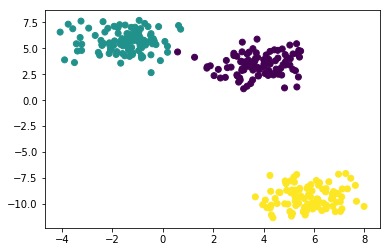

In [3]:
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [4]:
#定义模型参数和超参数
CLUSTER = 3
SAMPLES,FEATURES = X.shape
alpha = np.full(CLUSTER,1/CLUSTER)
mu = np.random.normal(size=(CLUSTER,FEATURES))
sigma = np.full((CLUSTER,FEATURES,FEATURES),np.diag(np.full(FEATURES,0.1)))
gamma = np.zeros((SAMPLES,CLUSTER))

In [5]:
def multi_gaussian(x,u,sig):
    '''计算多元高斯分布'''
    temp = -0.5*(x-u)@np.linalg.pinv(sig)@(x-u).T
    temp = np.exp(temp)
    temp *= 1/((2*np.pi)**(FEATURES/2))
    temp *= 1/(np.linalg.det(sig)**0.5)
    return temp

In [6]:
#计算一次gamma 即一次expectation
# gamma2 = np.zeros_like(gamma)
# for i in range(SAMPLES):
#     for j in range(CLUSTER):
#         x = X[i]
#         u = mu[j]
#         sig = sigma[j]
#         a = alpha[j]
#         gamma2[i,j] = a*multi_gaussian(x,u,sig)

# gamma2
# gamma2 = gamma2/np.sum(gamma2,axis=1,keepdims=True)

In [7]:
#更新u
def update_u(u,gamma,X):
    res = []
    for i in range(CLUSTER):
        u_i = (gamma[:,i][:,None]*X).sum(axis=0)/np.sum(gamma[:,i])
        res.append(u_i)
    
    return np.array(res)

# mu2 = update_u(mu,gamma,X)

In [8]:
#更新sig
def update_sig(sig,gamma,X,mu):
    res = []
    for i in range(CLUSTER):
        sig_i =  (X-mu[i]).T@(gamma[:,i][:,None]*(X-mu[i]))/np.sum(gamma[:,i])
        res.append(sig_i)

    return np.array(res)

# update_sig(sigma,gamma,X,mu2)
    

In [9]:
#更新alpha
def update_a(gamma):
    return np.mean(gamma,axis=0)

# update_a(gamma)

In [10]:
#main
for _ in range(100):
    #E
    for i in range(SAMPLES):
        for j in range(CLUSTER):
            x = X[i]
            u = mu[j]
            sig = sigma[j]
            a = alpha[j]
            gamma[i,j] = a*multi_gaussian(x,u,sig)
    gamma = gamma/np.sum(gamma,axis=1,keepdims=True)   
    #M
    alpha = update_a(gamma)  
    mu = update_u(mu,gamma,X)
    sigma = update_sig(sigma,gamma,X,mu)


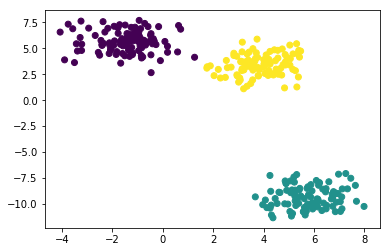

In [11]:
plt.scatter(X[:,0],X[:,1],c=gamma.argmax(axis=1))
plt.show()

#### 以下代码摘自 https://github.com/SmallVagetable 更透彻地封装了全过程

In [12]:
import numpy as np
import numbers
from scipy.stats import multivariate_normal

def distance(point1, point2):
    return np.sqrt(np.sum(np.square(point1 - point2), axis=1))


def check_random_state(seed):
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (numbers.Integral, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)


def sortLabel(label):
    label = np.array(label)
    labelOld = []
    labelNum = len(list(set(label)))
    for i in label:
        if i not in labelOld:
            labelOld.append(i)
        if len(labelOld) == labelNum:
            break

    labelNew = sorted(labelOld)
    for i, old in enumerate(labelOld):
        label[label == old] = labelNew[i] + 10000
    return label - 10000

def prob(x, mu, cov):
    norm = multivariate_normal(mean=mu, cov=cov)
    return norm.pdf(x)

def log_prob(x, mu, cov):
    norm = multivariate_normal(mean=mu, cov=cov)
    return norm.logpdf(x)


def log_weight_prob(x, alpha, mu, cov):
    N = x.shape[0]
    return np.mat(np.log(alpha) + log_prob(x, mu, cov)).reshape([N, 1])

In [13]:
from scipy.special import logsumexp




class GMM(object):
    def __init__(self, k, tol = 1e-3, reg_covar = 1e-7):
        self.K = k
        self.tol = tol
        self.reg_covar=reg_covar
        self.times = 100
        self.loglike = 0


    def fit(self, trainMat):
        self.X = trainMat
        self.N, self.D = trainMat.shape
        self.GMM_EM()

    # gmm入口
    def GMM_EM(self):
        self.scale_data()
        self.init_params()
        for i in range(self.times):
            log_prob_norm, self.gamma = self.e_step(self.X)
            self.mu, self.cov, self.alpha = self.m_step()
            newloglike = self.loglikelihood(log_prob_norm)
            # print(newloglike)
            if abs(newloglike - self.loglike) < self.tol:
                break
            self.loglike = newloglike


    #预测类别
    def predict(self, testMat):
        log_prob_norm, gamma = self.e_step(testMat)
        category = gamma.argmax(axis=1).flatten().tolist()[0]
        return np.array(category)


    #e步，估计gamma
    def e_step(self, data):
        gamma_log_prob = np.mat(np.zeros((self.N, self.K)))

        for k in range(self.K):
            gamma_log_prob[:, k] = log_weight_prob(data, self.alpha[k], self.mu[k], self.cov[k])
        
      

        log_prob_norm = logsumexp(gamma_log_prob, axis=1)
        log_gamma = gamma_log_prob - log_prob_norm[:, np.newaxis]
        return log_prob_norm, np.exp(log_gamma)


    #m步，最大化loglikelihood
    def m_step(self):
        newmu = np.zeros([self.K, self.D])
        newcov = []
        newalpha = np.zeros(self.K)
        for k in range(self.K):
            Nk = np.sum(self.gamma[:, k])
            newmu[k, :] = np.dot(self.gamma[:, k].T, self.X) / Nk
            cov_k = self.compute_cov(k, Nk)
            newcov.append(cov_k)
            newalpha[k] = Nk / self.N

        newcov = np.array(newcov)
        return newmu, newcov, newalpha


    #计算cov，防止非正定矩阵reg_covar
    def compute_cov(self, k, Nk):
        diff = np.mat(self.X - self.mu[k])
        cov = np.array(diff.T * np.multiply(diff, self.gamma[:,k]) / Nk)
        cov.flat[::self.D + 1] += self.reg_covar
        return cov


    #数据预处理
    def scale_data(self):
        for d in range(self.D):
            max_ = self.X[:, d].max()
            min_ = self.X[:, d].min()
            self.X[:, d] = (self.X[:, d] - min_) / (max_ - min_)
        self.xj_mean = np.mean(self.X, axis=0)
        self.xj_s = np.sqrt(np.var(self.X, axis=0))


    #初始化参数
    def init_params(self):
        self.mu = np.random.rand(self.K, self.D)
        self.mu = X[:self.K,:]
        self.cov = np.array([np.eye(self.D)] * self.K) * 0.1
        self.alpha = np.array([1.0 / self.K] * self.K)


    #log近似算法，可以防止underflow，overflow
    def loglikelihood(self, log_prob_norm):
        return np.sum(log_prob_norm)

In [14]:
gmm = GMM(3)
gmm.fit(X)

In [15]:
label = gmm.predict(X)

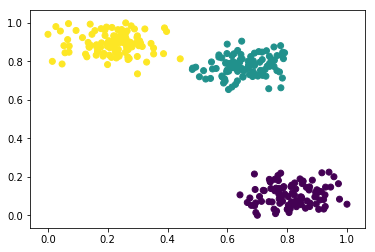

In [16]:
plt.scatter(X[:,0],X[:,1],c=label)
plt.show()